# Poisson Kriging - Area to Area Kriging

## Table of Contents:

1. Load areal and point data,
2. Load semivariogram (regularized),
3. Remove 40% of areal dataset,
4. Predict values at unknown locations,
5. Analyse Forecast Bias and Root Mean Squared Error of prediction.

## Level: Advanced

## Changelog

| Date | Change description                                                                                                    | Author |
|------|-----------------------------------------------------------------------------------------------------------------------|--------|
| 2023-01-14 | New area-to-area PK algorithm | @SimonMolinsky |
| 2022-10-21 | The tutorial was updated for the 0.3.4 version of the package                                                         | @SimonMolinsky |
| 2022-08-27 | The tutorial was updated for the 0.3.0 version of the package                                                         | @SimonMolinsky |
| 2021-12-14 | Sill selection was upgraded: now optimal sill is derived from the grid search within `TheoreticalSemivariogram` class | @SimonMolinsky |
| 2021-12-13 | Changed behavior of `select_values_in_range()` function                                                               | @SimonMolinsky |
| 2021-12-11 | Behavior of `prepare_kriging_data()` function has benn changed                                                        | @SimonMolinsky |
| 2021-05-28 | Updated paths for input/output data                                                                                   | @SimonMolinsky |
| 2021-05-11 | Refactored TheoreticalSemivariogram class                                                                             | @SimonMolinsky |
| 2021-03-31 | Update related to the change of semivariogram weighting. Updated cancer rates data.                                   | @SimonMolinsky |

## Introduction

Before starting this tutorial, be sure you understand concepts in the **Ordinary and Simple Kriging** and **Semivariogram Regularization** tutorials.

The Poisson Kriging technique is used to model spatial count data. We will analyze a particular case where values are counted over blocks, and those blocks may have irregular shapes and sizes. We will try to predict the breast cancer rates in the Northeastern counties of the U.S. We will use U.S. Census 2010 data to create point support for blocks.

> The breast cancer rates data and the point support population counts are located in the geopackage in a directory: `samples/regularization/cancer_data.gpkg`

In tutorial **Poisson Kriging - Centroid based approach** we've assumed that all areas have the same size and shape. It is not a valid statement. Now we use the Area-to-Area Kriging technique and predict and evaluate missing values.

Area-to-Area and Area-to-Point Poisson Kriging are slower than simplified Kriging with Centroids but give more reliable results because they are tuned to areal size and shape.

This tutorial covers the following steps:

1. Read and explore data,
2. Load semivariogram model,
3. Prepare training and test data,
4. Predict values of unknown locations and calculate forecast bias and root mean squared error,
5. Analyze error metrics.

## 1) Read and explore data

In [1]:
import numpy as np
import pandas as pd

from pyinterpolate import TheoreticalVariogram
from pyinterpolate import Blocks, PointSupport
from pyinterpolate import area_to_area_pk

In [2]:
DATASET = 'samples/regularization/cancer_data.gpkg'
OUTPUT = 'samples/regularization/regularized_variogram.json'
POLYGON_LAYER = 'areas'
POPULATION_LAYER = 'points'
POP10 = 'POP10'
GEOMETRY_COL = 'geometry'
POLYGON_ID = 'FIPS'
POLYGON_VALUE = 'rate'

blocks = Blocks()
blocks.from_file(DATASET, value_col=POLYGON_VALUE, index_col=POLYGON_ID, layer_name=POLYGON_LAYER)

point_support = PointSupport()
point_support.from_files(point_support_data_file=DATASET,
                         blocks_file=DATASET,
                         point_support_geometry_col=GEOMETRY_COL,
                         point_support_val_col=POP10,
                         blocks_geometry_col=GEOMETRY_COL,
                         blocks_index_col=POLYGON_ID,
                         use_point_support_crs=True,
                         point_support_layer_name=POPULATION_LAYER,
                         blocks_layer_name=POLYGON_LAYER)

<Axes: >

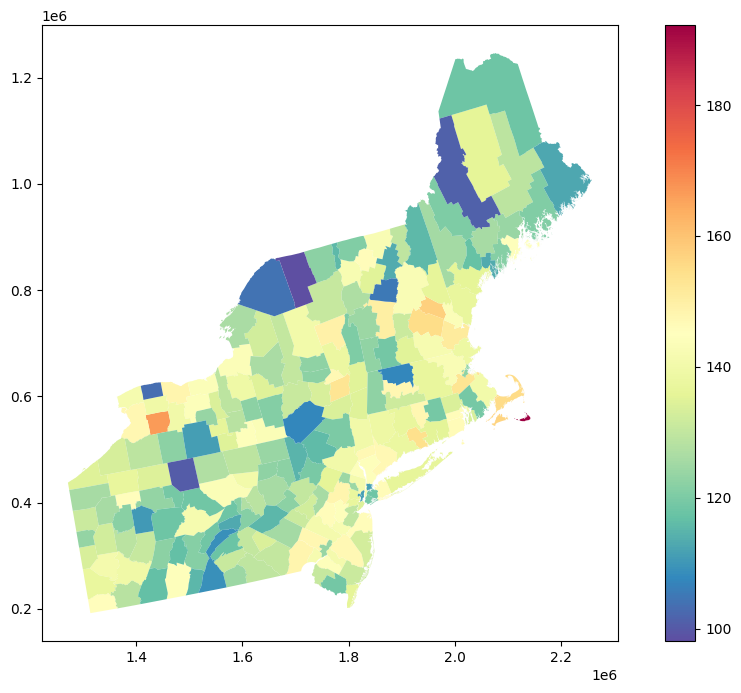

In [3]:
# Lets take a look into a map of areal counts

blocks.data.plot(column=blocks.value_column_name, cmap='Spectral_r', legend=True, figsize=(12, 8))

**Clarification**: It is a good idea to look into the spatial patterns in a dataset and to visually check if our data do not have any NaN values. We use the geopandas `GeoDataFrame.plot()` function with a color map that diverges regions based on the cancer incidence rates. The output choropleth map is not ideal, and (probably) it has a few unreliable results, for example:

- in counties with a small population, where the ratio number of cases to population size is high even if the number of cases is low,
- counties that are very big and sparsely populated may draw more of our attention instead of densely populated counties,
- transitions of colors (rates) between counties may be too abrupt, even if we know, that neighboring counties should have closer results.

We can overcome those problems using Area-to-Area Kriging for filtering and denoising. But, in this tutorial, we will make an interpolation with Area-to-Area Kriging and analyze root mean squared errors of predictions and their bias.

## 2) Load a semivariogram model

In this step, we load regularized semivariogram from the tutorial **Semivariogram Regularization (Intermediate)**. You can always perform semivariogram regularization along with the Poisson Kriging, but it is a very long process, and it is more convenient to separate those two steps.

In [4]:
semivariogram = TheoreticalVariogram()  # Create TheoreticalSemivariogram object
semivariogram.from_json('output/regularized_model.json')  # Load regularized semivariogram

## 3) Prepare training and test data.

We simply remove 40% of random ID's from the areal dataset (the same for points) and create four arrays: two training arrays with areal and point geometry and values and two test arrays with the same categories of data.

In [5]:
# Remove 40% of rows (values) to test our model

def create_test_areal_set(areal_dataset: Blocks, points_dataset: PointSupport, frac=0.4):
    """

    Parameters
    ----------
    areal_dataset : Blocks
    points_dataset : PointSupport
    frac : float

    Returns
    -------
    : List
        [[training_areas, test_areas, training_points, test_points]]
            equal to:
        [np.ndarray, np.ndarray, np.ndarray, np.ndarray]
            where:
        - areas: [[block index, centroid x, centroid y, value]]
        - point support: [[block id, x, y, value]]
    """
    block_id_col = areal_dataset.index_column_name
    block_data = areal_dataset.data.copy()
    all_ids = block_data[block_id_col].unique()
    training_set_size = int(len(all_ids) * (1 - frac))

    training_ids = np.random.choice(all_ids,
                                    size=training_set_size,
                                    replace=False)

    training_areas = block_data[block_data[block_id_col].isin(training_ids)]
    training_areas = training_areas[[block_id_col, 'centroid_x', 'centroid_y', areal_dataset.value_column_name]].values
    test_areas = block_data[~block_data[block_id_col].isin(training_ids)]
    test_areas = test_areas[[block_id_col, 'centroid_x', 'centroid_y', areal_dataset.value_column_name]].values

    ps_data = points_dataset.point_support.copy()
    ps_ids = points_dataset.block_index_column

    training_points = ps_data[ps_data[ps_ids].isin(training_ids)]
    training_points = training_points[[ps_ids,
                                       points_dataset.x_col,
                                       points_dataset.y_col,
                                       points_dataset.value_column]].values
    test_points = ps_data[~ps_data[ps_ids].isin(training_ids)]
    test_points = test_points[[ps_ids,
                               points_dataset.x_col,
                               points_dataset.y_col,
                               points_dataset.value_column]].values


    output = [training_areas, test_areas, training_points, test_points]
    return output

ar_train, ar_test, pt_train, pt_test = create_test_areal_set(blocks, point_support)

## 4) Predict values at unknown locations and calculate forecast bias and root mean squared error.

Do you know scikit-learn's fit-predict-transform estimation procedure? With Kriging, it is more complicated because we fit the semivariogram model to data, and we pass this fitted model into the kriging estimator.

You may start work with predictions with a fitted semivariogram model. The run of Area-to-Area Poisson Kriging requires five core arguments:

- semivariogram model (fitted semivariogram model),
- known areas (training set),
- known points (training set),
- unknown-block (without rate value),
- unknown block’s point support.

Additional parameters control the interpolation process:

- **number of observations** (the most critical parameter - how many neighbors are affecting your analysis area).

The algorithm in the cell below iteratively picks one location from the test set and performs interpolation. Then forecast bias, the difference between the actual and predicted value, is calculated. Forecast Bias is helpful in understanding if our algorithm predictions are too low or too high (under- or overestimation). The following parameter is Root Mean Squared Error. This measure tells us more about outliers and considerable differences between predictions and actual values. We will see it in the last part of the tutorial.

Your work with Poisson Kriging (or Kriging) will usually be the same:
- prepare training and test data,
- use training data to train the semivariogram model,
- test different hyperparameters with a test set to find the optimal number of neighbors which are affecting your area of analysis,
- forecast into unknown areas OR perform data smoothing.

In [6]:
number_of_obs = 6

predslist = []
for unknown_area in ar_test:
    upts = pt_test[pt_test[:, 0] == unknown_area[0]]
    upts = upts[:, 1:]
    # [unknown block index, prediction, error]
    try:
        kriging_preds = area_to_area_pk(
            semivariogram_model=semivariogram,
            blocks=ar_train,
            point_support=pt_train,
            unknown_block=unknown_area[:-1],
            unknown_block_point_support=upts,
            number_of_neighbors=number_of_obs,
            raise_when_negative_prediction=True,
            raise_when_negative_error=True
        )
    except ValueError:
        predslist.append([unknown_area[0], np.nan, np.nan, np.nan, np.nan])
    else:
        rmse = np.sqrt((kriging_preds[1] - unknown_area[-1])**2)
        fb = unknown_area[-1] - kriging_preds[1]
        kriging_preds.extend([rmse, fb, unknown_area[-1]])
        predslist.append(kriging_preds)

In [7]:
kriged_predictions = np.array(predslist)
pred_df = pd.DataFrame(data=kriged_predictions[:, 1:],
                       index=kriged_predictions[:, 0],
                       columns=['predicted', 'err', 'rmse', 'fb', 'real'])  # Store results in DataFrame

## 5) Analyze Forecast Bias and Root Mean Squared Error of prediction

The last step is the analysis of errors. We plot two histograms: forecast bias and root mean squared error then we calculate the base statistics of a dataset.

<Axes: ylabel='Frequency'>

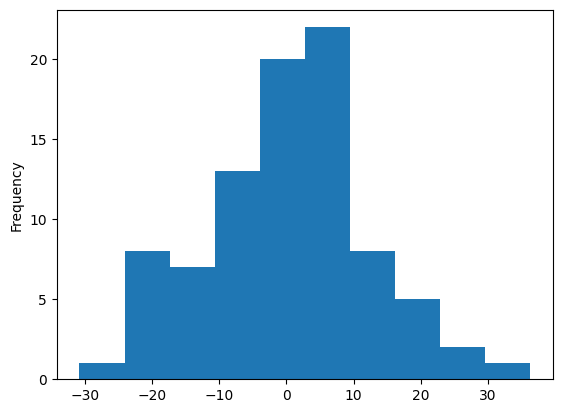

In [8]:
# Show histograms of errors

pred_df['fb'].plot.hist(bins=10)

<Axes: ylabel='Frequency'>

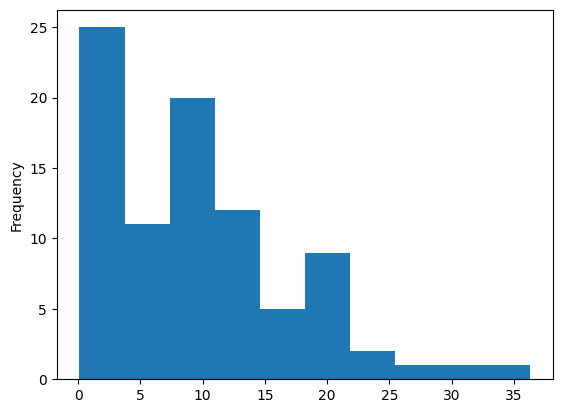

In [9]:
pred_df['rmse'].plot.hist(bins=10)

In [10]:
pred_df.describe()

,predicted,err,rmse,fb,real
count,87.000000,87.000000,87.000000,87.000000,87.000000
mean,130.967121,9.454705,9.757755,0.536327,131.503448
std,6.701142,1.440820,7.514070,12.348732,12.822169
min,115.238598,5.785818,0.102524,-30.806382,100.600000
25%,125.608855,8.594303,3.422416,-8.155451,122.100000
50%,131.343631,9.416905,8.833639,-0.231938,133.900000
75%,135.747964,10.398731,13.648570,8.835692,141.500000
max,150.642832,13.398354,36.316288,36.316288,166.800000


**Clarification**: Analysis of **Forecast Bias** and **Root Mean Squared Error** - their distribution and basic properties - could be a handy tool to analyze model performance. However, consider that table above is a single test case (realization) and can be misleading. The good idea is to repeat the test dozens of times with a different training/test set division each time. After this, we average results from multiple tests and get insight into how our model behaves.

**Note 1**: Those results are not decisive. Our sample has been selected randomly, and there is a chance that it is not a spatially representative sample! (E.g., areas only from one region). The good idea is to repeat the experiment multiple times with other samples and average results to determine how well the model performs.

**Note 2**: If we analyze errors’ statistics, we should consider not only the *mean* value of an error. Let’s take a look at different pieces of information:

- Histograms clearly show us how dispersed and grouped are errors, and what’s most important, we directly see the worse predictions and how many of them are generated by our model.
- What is plotted on a histogram, is described by statistics. We may check the max and the min error, but the true power comes when we analyze quartiles and standard deviation.
- The standard deviation is a good measurement of our model’s variance, the less, the better.
- Sometimes, we have to look into quartiles. A very high mean but relatively low median (or even the 3rd quartile) indicates that we have only a few wrong predictions, most of which are acceptable.

---